Notebook for cleaning (real-world) graphs from unrelated roads and apartment areas.

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
from imposm.parser import OSMParser
import networkx as nx
import pandas as pd
import numpy as np
import pickle as pkl
# import seaborn as sbn
import math
from tqdm import *
import re
import json

In [2]:
amenities = "amenity::(fast_food|bar|bbq|biergarten|cafe|food_court|ice_cream|pub|restaurant)"

In [3]:
def get_hours(tags):
    m = re.search("opening_hours::[A-z- ]*(\d+):(\d+)-(\d+):(\d+)",tags)
    m2 = re.search(amenities,tags)
    if m and m2:
        return int(float(m.group(3)) + float(m.group(4))/60. - float(m.group(1)) - float(m.group(2))/60.)
    else:
        return -1

In [4]:
get_hours("amenity::cafe;;cuisine::burger;;fvst:navnelbnr::23879;;name::Café Stygge;;opening_hours::10:30-22:00; Su off;;phone::+45 98142214;;website::http://cafestygge.dk/;;")

11

In [5]:
G = nx.Graph()
node_lat = {}
node_lon = {}
node_tags = {}
graph_id = 0
with open('../data/copenhagen_center.ntw','r') as f:
    t = f.readline().split()
    graph_id = int(t[0])
    print(t[0])
    nodes = int(t[1])
    edges = int(t[2])
    for i in range(edges):
        info = f.readline().split()
        id1 = int(info[0])
        id2 = int(info[1])
        assert(id1 < nodes)
        assert(id2 < nodes)
        G.add_edge(id1, id2, weight=info[2], etype=info[3])
    for i in range(nodes):
        info = f.readline().split()
        node_lat[i] = info[0]
        node_lon[i] = info[1]
        if (len(info) > 2):
            node_tags[i] = get_hours(info[2])
        else:
            node_tags[i] = -1
        if i not in G:
            G.add_node(i)
nx.set_node_attributes(G, 'lat', node_lat)
nx.set_node_attributes(G, 'lon', node_lon)

1506420325644495532


In [6]:
# build tree for points and find NN for each shop with working hours
from sklearn.neighbors import NearestNeighbors
import numpy as np
from scipy import spatial

#nodes of a graph
shop_points = []
shop_points_tags = []

i = 0
for node in G.nodes_iter():
    if node_tags[i] > -1:
        shop_points.append((float(G.node[node]['lat']), float(G.node[node]['lon'])))
        shop_points_tags.append(node_tags[i])
    i += 1

In [7]:
to_delete = []
for edge in nx.edges_iter(G):
    if G[edge[0]][edge[1]]["etype"] in ["unrelated",'cycleway','pedestrian','footway','steps','path']:
        to_delete.append(edge)
for e in to_delete:
    G.remove_edge(e[0],e[1])
    
to_delete = []
for node in nx.nodes_iter(G):
    if G.degree(node) < 1:
        to_delete.append(node)
for n in to_delete:
    G.remove_node(n)

In [8]:
len(G)

6807

In [9]:
graphs = list(nx.connected_component_subgraphs(G))
print(len(list(graphs)))
for g in graphs:
    if len(g) > 1000:
        print(len(g))

201
1272


In [10]:
for g in graphs:
    if len(g) > 1000:
        print(len(g))
        G = nx.convert_node_labels_to_integers(g)
        break

1272


In [11]:
len(list(nx.connected_component_subgraphs(G)))

1

In [12]:
# map shops
graph_points = []
for node in G.nodes_iter():
    graph_points.append((float(G.node[node]['lat']), float(G.node[node]['lon'])))
    
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(graph_points)
distances, indices = nbrs.kneighbors(shop_points)

hour_attr = {}
for i in range(len(shop_points)):
    hour_attr[indices[i][0]] = shop_points_tags[i]

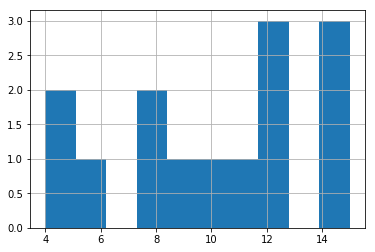

In [13]:
pd.Series(hour_attr).hist()

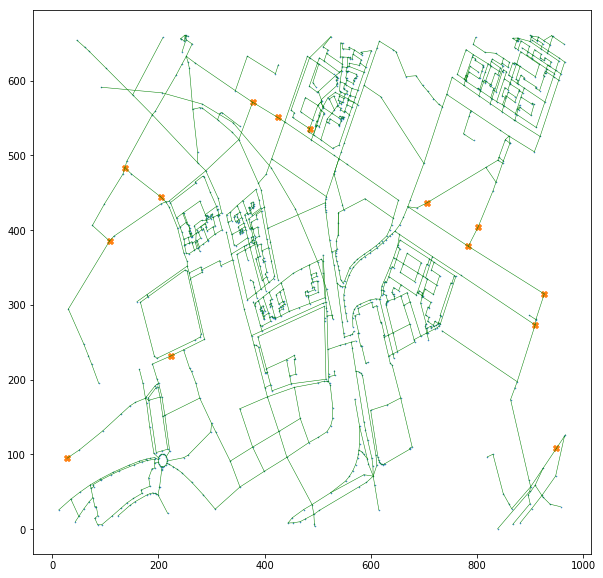

In [14]:
# print customers (shops)
# do not run for large graphs!

#get customers
facility_coords = []
for key in hour_attr:
    facility_coords.append((G.node[key]['lat'], G.node[key]['lon']))

plt.figure(dpi=72,figsize=(10,10))
        
for edge in nx.edges_iter(G):
    t = G[edge[0]][edge[1]]['etype'] 
#     plt.plot([G.node[edge[0]]['lat'],G.node[edge[1]]['lat']],
#              [G.node[edge[0]]['lon'],G.node[edge[1]]['lon']],color=color_map[t],linewidth=0.5)
    plt.plot([G.node[edge[0]]['lat'],G.node[edge[1]]['lat']],
             [G.node[edge[0]]['lon'],G.node[edge[1]]['lon']],color="g",linewidth=0.5)

tmp = []
for node in nx.nodes_iter(G):
    if len(G.node[node]) > 0:
        tmp.append([G.node[node]['lat'],G.node[node]['lon']])
tmp = np.array(tmp).T
plt.scatter(tmp[0],tmp[1],marker='.',s=1)

tmp = np.array(facility_coords).T
plt.scatter(tmp[0],tmp[1],marker='X')

## Export with random customers

In [73]:
def export_graph(path, graph_id, sources):
    '''
    Sources is a vector with ids of source nodes
    '''
    new_node_map = {}
    i = 0
    for n in G.nodes(data=True):
        new_node_map[n[0]] = i
        i += 1

    with open(path + str(graph_id) + ".ntw",'w') as f:
        f.write("%d %d %d %d\n" % (graph_id, len(G), nx.number_of_edges(G), len(sources))) 
        for e in G.edges(data=True):
            f.write("%d %d %s\n" % (new_node_map[e[0]], new_node_map[e[1]], e[2]['weight']))
        for i in sources:
            f.write("%d\n" % i)
        i = 0
        for n in G.nodes(data=True):
            assert(new_node_map[n[0]] == i)
            i += 1
            f.write("%s %s\n" % (n[1]['lat'], n[1]['lon']))

In [15]:
#export with certain number of customers and readible format - create for multiple source count (many files)
new_node_map = {}
i = 0
for n in G.nodes(data=True):
    new_node_map[n[0]] = i
    i += 1

for sources in tqdm([2**x for x in range(7,17)]):  
    export_graph('../data/aalborg/modified/', graph_id+1, sources)

100%|██████████| 10/10 [00:00<00:00, 24.23it/s]


## Export with population-based customers and potential facilities

In [10]:
def transform_point(point):
    lat = point[1]
    lon = point[0]
    lat0 = 55.677
    lon0 = 12.5767
    dlat = lat - lat0;
    dlon = lon - lon0;
    latitudeCircumference = 40075160. * math.cos(lat0 * math.pi/180.0);
    resX = dlon * latitudeCircumference / 360. ;
    resY = dlat * 40008000. / 360. ;
    return [resX, resY]

def transform_coords(polygon):
    new_polygon = []
    for point in polygon:
        new_polygon.append(transform_point(point))
    return new_polygon

In [45]:
# load geojson with regions
import json

from shapely.geometry import MultiPolygon, Polygon, Point

f = open("../data/cph-regions.geojson","r")
data = json.loads(f.read())


regions = {}
for j in range(len(data['features'])):
#     print transform_coords(data['features'][j]['geometry']['coordinates'][i][0])
#     break
    m = MultiPolygon([Polygon(transform_coords(data['features'][j]['geometry']['coordinates'][i][0]))
                      for i in range(len(data['features'][j]['geometry']['coordinates']))])
    regions[int(data['features'][j]['properties']['rode_nr'])] = m

regions

{1: <shapely.geometry.multipolygon.MultiPolygon at 0x116d96c90>,
 2: <shapely.geometry.multipolygon.MultiPolygon at 0x116d96f10>,
 3: <shapely.geometry.multipolygon.MultiPolygon at 0x116d96ad0>,
 4: <shapely.geometry.multipolygon.MultiPolygon at 0x115611710>,
 5: <shapely.geometry.multipolygon.MultiPolygon at 0x116d96410>,
 6: <shapely.geometry.multipolygon.MultiPolygon at 0x116d96f50>,
 7: <shapely.geometry.multipolygon.MultiPolygon at 0x116d96f90>,
 8: <shapely.geometry.multipolygon.MultiPolygon at 0x116d96fd0>,
 9: <shapely.geometry.multipolygon.MultiPolygon at 0x116d96490>,
 10: <shapely.geometry.multipolygon.MultiPolygon at 0x116d85d10>,
 11: <shapely.geometry.multipolygon.MultiPolygon at 0x116d85f50>,
 12: <shapely.geometry.multipolygon.MultiPolygon at 0x116d85cd0>,
 13: <shapely.geometry.multipolygon.MultiPolygon at 0x116d85d90>,
 14: <shapely.geometry.multipolygon.MultiPolygon at 0x116d85e10>,
 15: <shapely.geometry.multipolygon.MultiPolygon at 0x115f6c8d0>,
 16: <shapely.geome

In [18]:
# map population of the latest year to each of regions
population = pd.read_csv("../data/cph-population.csv")
population = population[population["AAR"] == population["AAR"].max()]

In [19]:
population.head()

,AAR,RODE,KOEN,ALDER,PERSONER
0,2015,1,1,0,6
1,2015,1,1,1,6
2,2015,1,1,3,3
3,2015,1,1,4,4
4,2015,1,1,5,3


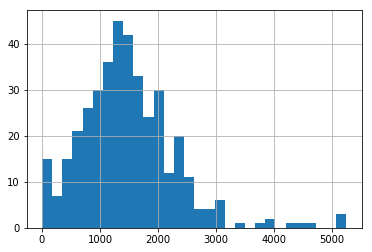

In [22]:
pop_map = population[['RODE','PERSONER']].groupby("RODE",as_index=False).sum()
pop_map['PERSONER'].hist(bins=30)

In [28]:
pop_map.head()

,RODE,PERSONER
0,1,549
1,2,698
2,3,385
3,4,295
4,5,251


In [23]:
from shapely.geometry import MultiPolygon, Polygon, Point
def get_region_id(lat, lon):
    p = Point(lat, lon)
    for k in regions:
        if (regions[k].contains(p)):
            return k
    return -1

In [42]:
# assign each graph node a corresponding distrinct (region)
node_region_id = {}
region_node_list = {}
for node in tqdm(nx.nodes_iter(G)):
    reg_id = get_region_id(float(G.node[node]["lat"]), float(G.node[node]["lon"]))
#     if (reg_id == -1):
#         print "no"
#         break
    node_region_id[node] = reg_id
    if reg_id not in region_node_list:
        region_node_list[reg_id] = []
    region_node_list[reg_id].append(node)

1272it [00:00, 2252.99it/s]


In [43]:
pd.Series(node_region_id).value_counts()

 18    185
 30    183
 15    179
 22    168
 12    151
 11    125
 19     80
 14     60
 16     43
 24     24
 29     15
 20     11
 9      11
 17     10
 21      8
 10      7
 23      5
-1       3
 13      2
 7       2
dtype: int64

In [47]:
# make a probability vector so that prob(reg)=normalized (#people/#nodes)
probability_vector = []
probability_index = {}
s = 0
for region_id in regions:
    probability_index[region_id] = len(probability_vector)
    if region_id in region_node_list:
        if (len(pop_map[pop_map["RODE"] == region_id]) == 0):
            val = 0
        else:
            val = float(pop_map[pop_map["RODE"] == region_id]["PERSONER"]) / len(region_node_list[region_id])
            s += val
        probability_vector.append(val)
    else:
        probability_vector.append(0)

probability_vector = np.array(probability_vector)
probability_vector = probability_vector/np.sum(probability_vector)

In [75]:
# save graph with customers
for number_of_customers in {10}:
    customer_node_ids = np.random.choice(len(probability_vector), 
                                         number_of_customers, 
                                         p=probability_vector, 
                                         replace=False)
    export_graph("./", graph_id+1, customer_node_ids)

In [91]:
# save potential facility locations in a separate file, one file per one city
capacity_scale = 0.4
df = pd.Series(capacity_scale*pd.Series(hour_attr),dtype=int)
df.to_csv("facility_location_hours.csv",sep=" ")
df.mean()

3.6428571428571428

# Plotting

In [266]:
# plot results : plot map with regions, density and random customer assignment


# plots : all city of copenhagen; road map of copenhagen (using construction hierarchies); people density; 
# facility scatter; center with facilities and customers scattered randomly;

In [11]:
import geopandas as gp
glaciers = gp.GeoDataFrame.from_file('../data/cph-regions.geojson')
f = open("../data/cph-regions.geojson","r")
data = json.loads(f.read())
for j in range(len(data['features'])):
    for i in range(len(data['features'][j]['geometry']['coordinates'])):
        data['features'][j]['geometry']['coordinates'][i][0] = transform_coords(data['features'][j]['geometry']['coordinates'][i][0])
with open("tmp.txt","w") as f:
    f.write(json.dumps(data))
glaciers = gp.GeoDataFrame.from_file("tmp.txt")
glaciers.head()

,bydel,rode_nr,areal_m2,distrikt_nr,rodenavn,id,geometry
0,Østerbro,99,,7,Bellmans,111,"(POLYGON ((-1137.63229181488 4238.00385120971,..."
1,Indre by,17,,1,Holmens,9,(POLYGON ((370.4934657375431 -28.7004139420659...
2,Valby,227,,22,Flaskekroens,255,(POLYGON ((-5412.165050265035 -3392.7878997698...
3,Indre by,2,,1,Bispegårdens,12,(POLYGON ((-655.6850471244161 173.375625876342...
4,Indre by,3,,1,Rådhusets,13,(POLYGON ((-518.3399199642896 -32.989684665054...


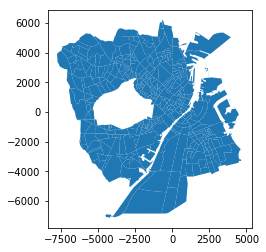

In [12]:
glaciers.plot()

In [13]:
glaciers["dens"] = glaciers["rode_nr"].apply(lambda rodeid: probability_vector[probability_index[rodeid]])
glaciers

NameError: global name 'probability_vector' is not defined

/usr/local/lib/python2.7/site-packages/geopandas/plotting.py:381: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


KeyError: 'dens'

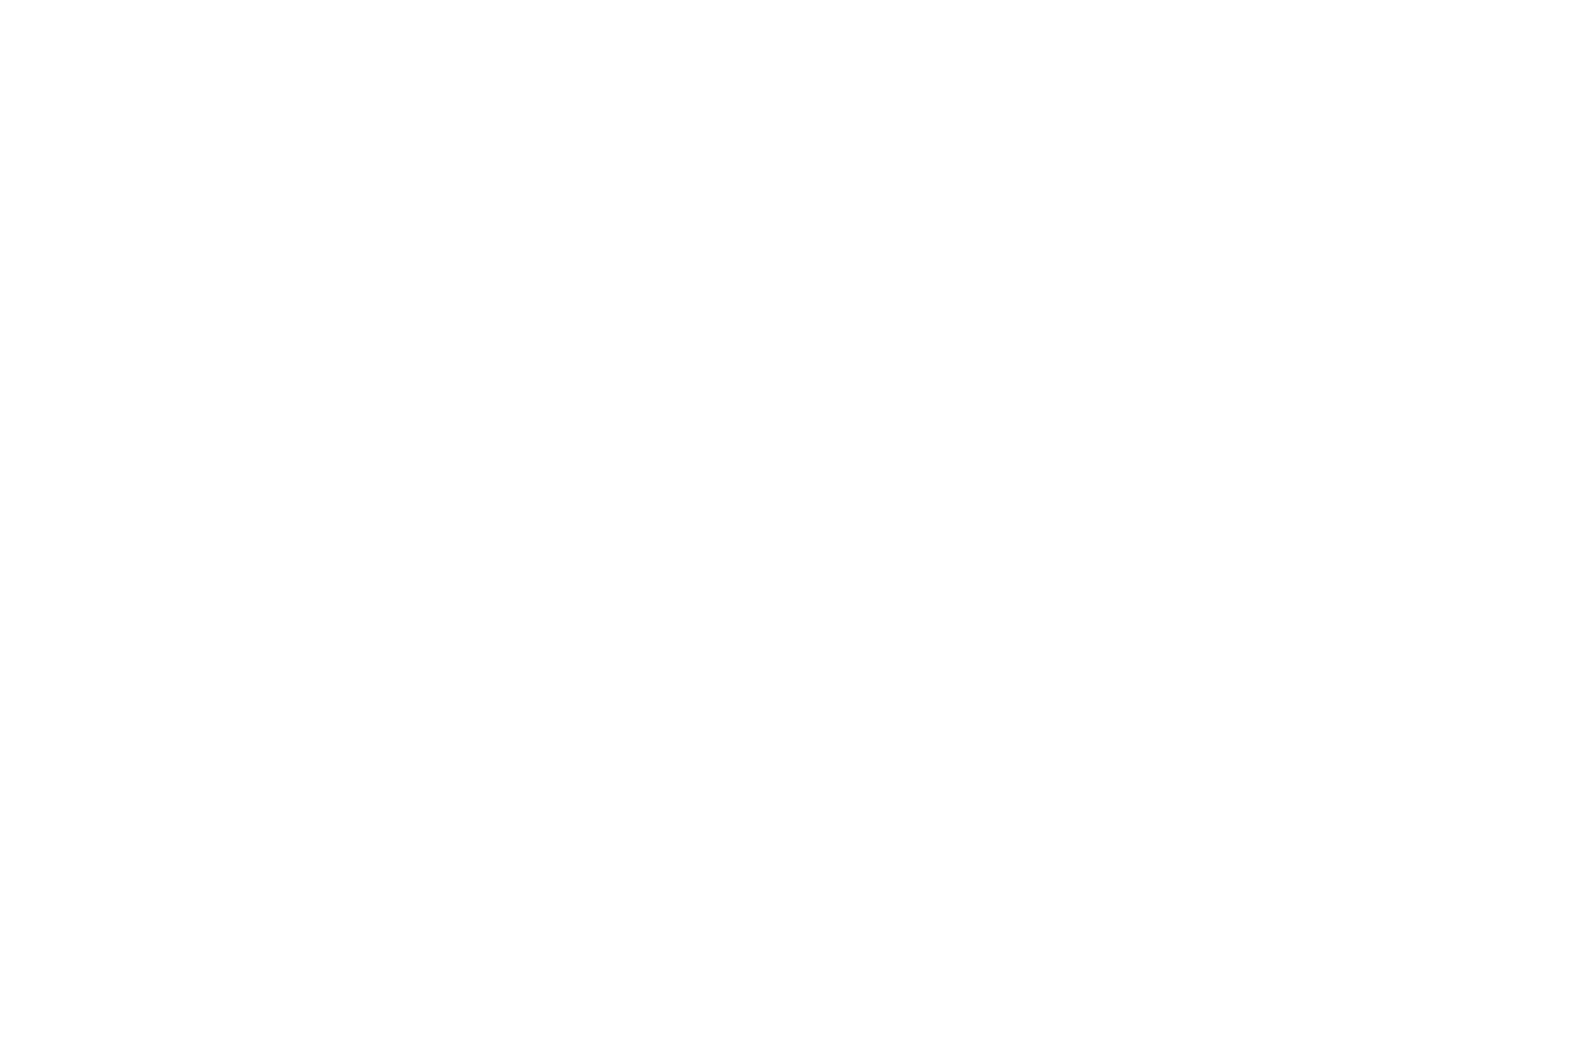

In [14]:
fig, ax1 = plt.subplots(1, dpi=300)
ax1.set_axis_off()
glaciers.plot(categorical=False,column="dens",colormap="Blues",ax=ax1, legend=True)

In [ ]:
# plot road network graph - http://geoffboeing.com/2016/11/osmnx-python-street-networks/

In [ ]:
# plot center network with assigned customers and facilities

In [2]:
import osmnx as ox
ox.plot_graph(ox.graph_from_place('Modena, Italy'))

TypeError: 'instancemethod' object has no attribute '__getitem__'